**DSCI 100 GROUP REPORT:  
A CLASSIFICATION MODEL TO DETECT PHISHING WEBSITES**

**INTRODUCTION:**  

The term phishing is defined as the fraudulent attempt to obtain sensitive information such as usernames, passwords and credit card details by disguising oneself as a trustworthy entity in an electronic communication. The purpose of a phishing website is to steal personal information or other confidential information by tricking the victim into believing that the website is legitimate.

With this project we calculate the accuracy of a statistical classifier to predict if a website was a legitimate service, a phishing scam, or somewhere in between based on the several features. We can also find out what features are more common and specific to the phishing websites than legitimate ones, or if there are other features that are falsely associated with phishing websites.

The large data set that we are using was obtained from a machine learning database: https://archive.ics.uci.edu/ml/machine-learning-databases/00327/ and it consists of sound and effective features that characterize phishing websites. These features are usually evaluated while making a model that distinguishes between legitimate and phishing websites. We will be using these features to construct our model and we also aim to find out which of these features are more common than other features among phishing websites. 


**METHODS:**  

The dataset was loaded from "http://archive.ics.uci.edu/ml/machine-learning-databases/00327/Training%20Dataset.arff", converted into a caret-friendly form (result as factor), and cut down to a manageable size (3700 observations).

Afterwards, basic summary statistics about the dataset (frequency/relative abundance of predictor type variables and result type variables) were generated to make sure the data was balanced and complete (no NAs). Two tables and a bar chart were used to visualize the data distribution.   

Lastly, a knn classification analysis was performed. Five fold cross validation was performed to choose the k which maximized the accuracy of the model across the training data, and that k was used to generate the final classifier. The accuracy for different k's was generated in a line plot to visualize this process.

**Here we load the dataset from the internet, and briefly describe the variables involved.**

In [1]:
# Load some libraries
library(tidyverse)
library(repr)
library(caret)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa



In [2]:
# Brute force column names from data
phishing_columns <- c("having_IP_address","URL_Length","Shortening_Service","having_At_Symbol",
                     "double_slash_redirecting","Prefix_Suffix","having_Sub_Domain","SSLfinal_State",
                     "Domain_registration_length","Favicon","port","HTTPS_token","Request_URL",
                     "URL_of_Anchor","Links_in_tags","SFH","Submitting_to_email","Abnormal_URL",
                     "Redirect","on_mouseover","RightClick","popUpWindow","Iframe","age_of_domain",
                     "DNSRecord","web_traffic","Page_Rank","Google_Index","Links_pointing_to_page",
                     "Statistical_report","Result")

# Load data from http because https is giving a certificate expiry error
Table_1_Raw_Phishing_Data <- "http://archive.ics.uci.edu/ml/machine-learning-databases/00327/Training%20Dataset.arff" %>%
            read_csv(skip = 36, col_names = phishing_columns)

Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


In [3]:
head(Table_1_Raw_Phishing_Data)

having_IP_address,URL_Length,Shortening_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registration_length,Favicon,⋯,popUpWindow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1,1,1,1,-1,-1,-1,-1,-1,1,⋯,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,-1,0,1,-1,1,⋯,1,1,-1,-1,0,-1,1,1,1,-1
1,0,1,1,1,-1,-1,-1,-1,1,⋯,1,1,1,-1,1,-1,1,0,-1,-1
1,0,1,1,1,-1,-1,-1,1,1,⋯,1,1,-1,-1,1,-1,1,-1,1,-1
1,0,-1,1,1,-1,1,1,-1,1,⋯,-1,1,-1,-1,0,-1,1,1,1,1
-1,0,-1,1,-1,-1,1,1,-1,1,⋯,1,1,1,1,1,-1,1,-1,-1,1


Here is an overview description of the variables we are interested in. (There were 30 predictor variables total, but we decided to focus on the following 12 predictors for efficiency.)

- URL_Length: 1 if URL is more than 75 characters in length, 0 if URL is between 54 and 75 characters in length, -1 otherwise
- having_At_Symbol: 1 if URL has an @ symbol, -1 otherwise
- Prefix_Suffix: 1 if URL contains "-", -1 otherwise
- Favicon: 1 if Favicon loaded from external domain, -1 otherwise
- port: 1 if unsecure port used, -1 if otherwise
- SFH: 1 if SFH is "about: blank", 0 if SFH refers to different domain, -1 otherwise
- Submitting_to_email: 1 if "mail()" or "mailto" is used, -1 otherwise
- Abnormal_URL: 1 if URL does not contain host name, -1 otherwise
- Redirect: 1 if webpage redirects is greater than 3, 0 if between 2 or 3 redirects used, (-1 not present here)
- on_mouseover: 1 if mousing over a link on the site changes the status bar, -1 otherwise
- popUpWindow: 1 if popup windows contain text fields, -1 otherwise
- Iframe: 1 if iframe (html embedded in document) used, -1 otherwise
- Statistical_report: 1 if host belongs to top phishing IPs/domains, -1 otherwise

Result: -1 is legitimate, 1 is phishing. This is the general case for all the variables.

The next step would be to wrangle the data and make it tidy to perform classification. Luckily for us, in this dataset, every row is an observation (a known phishing website), every column is a variable (a feature associated with the phishing website), and every cell is its own value (Legitimate: -1, Phishing: 1). Hence, this data is tidy. 

**Here we wrangle and split the data into training, and testing sets.**

In [4]:
set.seed(2020)
# Paring down dataset to what we will be working with.
# Columns selected were based on initial guesses about which variables would be 
#         most important, not on any statistical analysis (because the entire point
#         of subsetting the variables is that doing statistical analysis on all of them
#         would wreak havoc on our kernel/take forever)
working_columns <- c("URL_Length","having_At_Symbol","Prefix_Suffix","Favicon","port", 
                     "SFH","Abnormal_URL","Redirect","on_mouseover","popUpWindow", 
                     "Iframe","Statistical_report","Result")

# This is the most data we could get caret to run on
# with datasets bigger than about 3700 cross validation starts returning errors
# i.e. "too many ties in knn" stops caret in its tracks (below it's still there, but it runs smoothly)
working_data_raw <- sample_n(Table_1_Raw_Phishing_Data, size = 3700) 


# Turn result into factor, select columns of interest
working_data <- mutate(working_data_raw, Result = as.factor(Result)) %>% select(working_columns)

# Splitting data into training and testing sets
training_rows <- working_data %>% select(Result) %>% unlist() %>% createDataPartition(p=0.75, list=FALSE)
training_data <- working_data %>% slice(training_rows)
testing_data <- working_data %>% slice(-training_rows)
X_train <- training_data %>% select(-Result) %>% data.frame()
Y_train <- training_data %>% select(Result) %>% unlist()
X_test <- testing_data %>% select(-Result) %>% data.frame()
Y_test <- testing_data %>% select(Result) %>% unlist()

**Here we generate some basic summary statistics about the training data, like the number of values missing and relative abundance of observations in each class.**

In [5]:
# Make a table containing a count of observations in each class
# NOTICE: na.rm = FALSE means that if there are any NA values in the data we will see them later
summary_tidy <- training_data %>% gather(key = "Column", value = "Observation", na.rm = FALSE)
summary_tibble <- summary_tidy %>% group_by(Column,Observation) %>% summarize(count = n()) %>%
                  as_tibble()

# Generate a table of predictor variable abundance that we will use later in making a plot
Table_2_Summary_Statistics_For_Predictors <- summary_tibble %>% filter(Column != "Result") %>%
                         spread(key = Column, value = count, fill = 0)

# Set aside a separate table for the result observations because 
#           that's the main class balance we are concerned about
Table_3_Summary_Statistics_For_Result_Variable <- summary_tibble %>% filter(Column == "Result") %>% 
                    select(-Column) %>% mutate(abundance = round(count / 27.76))
colnames(Table_3_Summary_Statistics_For_Result_Variable) <- c("Result","Count","Percent abundance")

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

In [6]:
Table_2_Summary_Statistics_For_Predictors

Observation,Abnormal_URL,Favicon,having_At_Symbol,Iframe,on_mouseover,popUpWindow,port,Prefix_Suffix,Redirect,SFH,Statistical_report,URL_Length
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1,419,518,427,261,326,549,377,2401,0,2121,372,2240
0,0,0,0,0,0,0,0,0,2436,198,0,31
1,2357,2258,2349,2515,2450,2227,2399,375,340,457,2404,505


In [7]:
Table_3_Summary_Statistics_For_Result_Variable

Result,Count,Percent abundance
<chr>,<int>,<dbl>
-1,1247,45
1,1529,55


There are advantages to this data. As shown above, observations for the result variable are relatively balanced. This means we don't have to scale the data because:  

(a) it's already pretty balanced, and  
 (b) it's all categorical!  
 
Additionally, as shown by na.rm = FALSE, there are no missing data points in our dataset.  

However, this data also has its drawbacks. The main problem with this data is that we can't visualize it very well. As our dataset is composed mainly of categorical variables, bivariate scatterplots would yield a bunch of points stacked right on top of each other at (-1, -1), (-1, 1), (1, -1), and (1, 1). 
We're going to try and get around this visualization problem by using ggpairs later, but just note as an aside that categorical predictors are best visualized using a decision-tree type algorithm and tree diagram, which isn't applicable to our current data analysis.


**We did not include the means of the predictors because all predictors were categorical and the mean would be meaningless. Instead, we included the relative distribution of predictors in the plot below.**

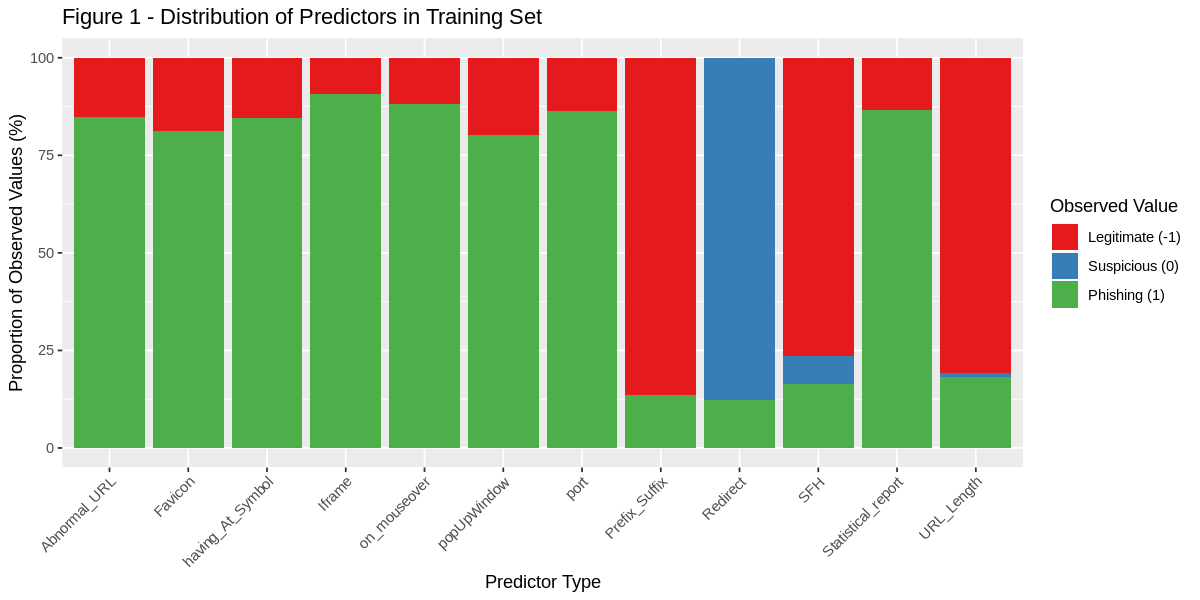

In [8]:
# generate plot from the above table regarding only predictor variables
library(RColorBrewer)
options(repr.plot.width = 10, repr.plot.height = 5)
(predictor_dist_plot <- summary_tibble %>% filter(Column != "Result") %>%
                     ggplot(aes(x = Column, y = count / 27.76, fill = Observation)) +
                     geom_bar(stat = "identity") +
                     scale_fill_brewer(palette = "Set1", 
                                        labels = c("Legitimate (-1)","Suspicious (0)","Phishing (1)")) +
                     labs(x = "Predictor Type", 
                          y = "Proportion of Observed Values (%)",
                         fill = "Observed Value") +
                     theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                     ggtitle("Figure 1 - Distribution of Predictors in Training Set"))

**Below, we perform 5 fold cross-validation, and then train a model based on the best k.**

In [9]:
# Performing five-fold cross-validation to pick k
ks <- data.frame(k = seq(from = 1, to = 31, by = 2))
train_control <- trainControl(method = "cv", number = 5)
(choose_k_all <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = ks, trControl = train_control))

k-Nearest Neighbors 

2776 samples
  12 predictor
   2 classes: '-1', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2222, 2220, 2221, 2220, 2221 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.6948949  0.4005561
   3  0.6905777  0.3925129
   5  0.6873299  0.3864555
   7  0.6848146  0.3824685
   9  0.6776145  0.3687158
  11  0.6765347  0.3663173
  13  0.6779768  0.3688963
  15  0.6808551  0.3739769
  17  0.6794111  0.3708429
  19  0.6768944  0.3660044
  21  0.6772548  0.3664707
  23  0.6740161  0.3603329
  25  0.6732973  0.3592767
  27  0.6740219  0.3608373
  29  0.6751017  0.3627196
  31  0.6743771  0.3611445

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 1.

**The cross-validation process is visualized below by a plot of accuracy versus different values of k.**

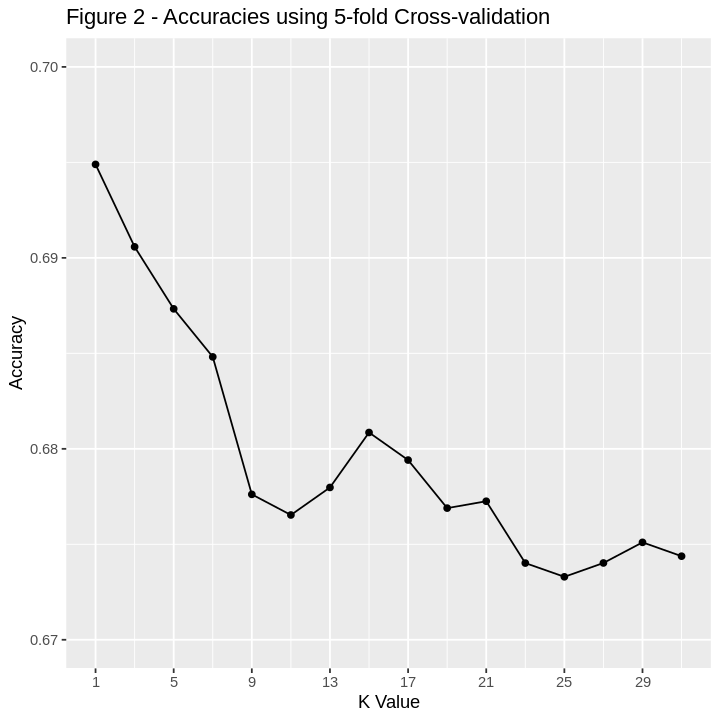

In [10]:
# Visualizing the different accuracies vs their k values
options(repr.plot.width=6, repr.plot.height=6)
(accuracies_all_plot <- choose_k_all$results %>%
    select(k, Accuracy) %>%
    ggplot(aes(x=k,y=Accuracy)) +
    geom_point() +
    geom_line() +
    labs(x = "K Value",
         y = "Accuracy", 
         title = "Figure 2 - Accuracies using 5-fold Cross-validation") +
    scale_x_continuous(breaks = seq(from = 1, to = 31, by = 4)) +
    scale_y_continuous(limit = c(0.67, 0.70)))


As seen above, the most accurate model is obtained by using k = 1, although the absolute accuracy difference between k = 1 and k = 31 is very small, and the upper bound on accuracy seems to be 69.5%. This suggests that either phishing websites and legitimate websites may have more in common than we first thought, or we can only have so much confidence in a model which focuses on a subset of the data, or a combination of both.

In [11]:
# Training final model on k = 1, and displaying confusion matrix
knn_final_model <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = data.frame(k = 1))
predictions_all <- predict(knn_final_model, X_test)
(model_qual <- confusionMatrix(data = predictions_all, reference = Y_test))

Warning message:
“predictions failed for Resample02: k=1 Error in knn3Train(train = structure(c(1, -1, -1, -1, -1, -1, 1, -1, -1,  : 
  too many ties in knn
”Warning message:
“predictions failed for Resample03: k=1 Error in knn3Train(train = structure(c(-1, -1, -1, -1, -1, -1, -1, -1,  : 
  too many ties in knn
”Warning message:
“predictions failed for Resample06: k=1 Error in knn3Train(train = structure(c(1, -1, -1, -1, -1, -1, -1, -1,  : 
  too many ties in knn
”Warning message:
“predictions failed for Resample09: k=1 Error in knn3Train(train = structure(c(-1, -1, 1, -1, -1, -1, -1, -1,  : 
  too many ties in knn
”Warning message:
“predictions failed for Resample12: k=1 Error in knn3Train(train = structure(c(-1, -1, 1, -1, -1, -1, -1, -1,  : 
  too many ties in knn
”Warning message:
“predictions failed for Resample14: k=1 Error in knn3Train(train = structure(c(1, 1, 1, 1, -1, -1, -1, -1, -1,  : 
  too many ties in knn
”Warning message:
“predictions failed for Resample16: k=1 Error in

Confusion Matrix and Statistics

          Reference
Prediction  -1   1
        -1 345 211
        1   70 298
                                          
               Accuracy : 0.6959          
                 95% CI : (0.6651, 0.7254)
    No Information Rate : 0.5509          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4041          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8313          
            Specificity : 0.5855          
         Pos Pred Value : 0.6205          
         Neg Pred Value : 0.8098          
             Prevalence : 0.4491          
         Detection Rate : 0.3734          
   Detection Prevalence : 0.6017          
      Balanced Accuracy : 0.7084          
                                          
       'Positive' Class : -1              
                              

Wow! That's a lot of error messages. Don't worry, it doesn't have a drastic effect on the final result. caret shows us those error messages because the data is categorical, and as a result there are a lot of neighbours equidistant from some of our testing observations. There's no way to get around this using categorical predictors in knn classification, and for the most part it runs smoothly anyway.  

As you can see above, the final accuracy of this model is about 69.5%.

**Here we visualize the general trends in the dataset classification by plotting a row from ggpairs correlation.**

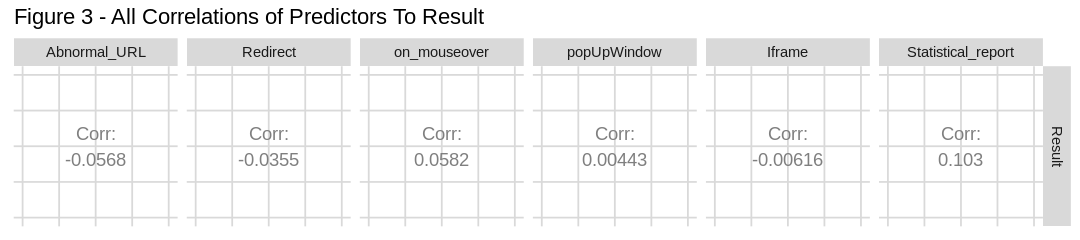

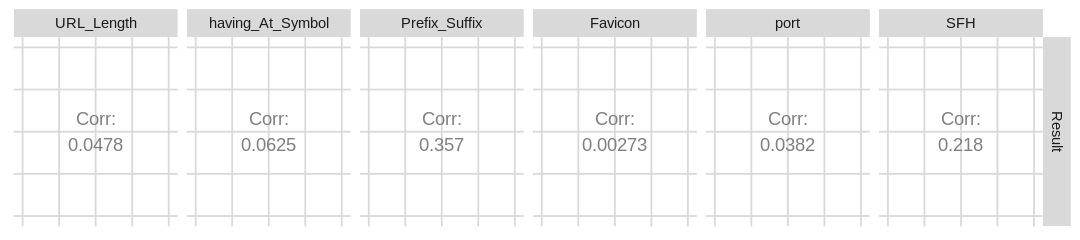

In [12]:
options(repr.plot.width=9, repr.plot.height=2)
# Create two rows because 12 variables won't fit nicely into one ggpairs row
phishing_pairs_1 <- working_data %>% mutate(Result = as.double(Result)) %>% 
                    select(Result,Abnormal_URL:Statistical_report) %>% ggpairs()
phishing_pairs_2 <- working_data %>% mutate(Result = as.double(Result)) %>% 
                    select(Result,URL_Length:SFH) %>% ggpairs()
phishing_labels_1 <- phishing_pairs_1$xAxisLabels %>% tibble() %>% filter(. != "Result") %>% unlist()
phishing_labels_2 <- phishing_pairs_2$xAxisLabels %>% tibble() %>% filter(. != "Result") %>% unlist()
row_1 <- lapply(2:phishing_pairs_1$ncol, function(x) getPlot(phishing_pairs_1, i = 1, j = x))
row_2 <- lapply(2:phishing_pairs_2$ncol, function(x) getPlot(phishing_pairs_2, i = 1, j = x))
                
# Print the two rows of ggpairs on top of each other
ggmatrix(row_1, nrow = 1, ncol = phishing_pairs_1$ncol - 1, 
         xAxisLabels = phishing_labels_1, 
         yAxisLabels = "Result") +
        theme(axis.text.x=element_blank(),
            axis.ticks.x=element_blank(),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank()) +
        ggtitle("Figure 3 - All Correlations of Predictors To Result")
ggmatrix(row_2, nrow = 1, ncol = phishing_pairs_2$ncol - 1, 
         xAxisLabels = phishing_labels_2, 
         yAxisLabels = "Result") +
        theme(axis.text.x=element_blank(),
            axis.ticks.x=element_blank(),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank())



**RESULTS:** 

In summary, using a basic knn classification model to predict phishing sites with 5-fold cross validation, it was found that k = 1 yielded the highest accuracy (0.6949) across the training data (Figure 2). Additionally, the final model trained on k = 1 performed modestly well on the testing data, with an accuracy of 0.6959. The most important predictor of phishing websites turned out to be whether the url contained a hyphen (Prefix_Suffix), and whether the SFH is blank (SFH) (Figure 3).

**DISCUSSION:**
 
As stated above, the most important predictors of a website’s legitimacy seemed to be SFH, which looks at whether the server form handler is “about:blank”, and Prefix_Suffix, which looks at whether the website’s url contains a hyphen. We expected that SFH would be pretty important, as form handlers deal with information submitted from the user in forms (Satapathy, Senkerik,  Somanah, Bhateja, & Yang, 2019), so it’s not that hard to see why a form handler that claims it’s doing nothing with that data would be incredibly suspicious. What surprised us was the presence of a hyphen in the url being so indicative of a phishing website. This correlation may have been due to the fact that hyphens are not used in domain names, typically reserved for naming directories or subfolders (MOZ, n.d.), and that hyphenated domain name would indicate an unprofessional developer who is less likely to be known and trusted.

 
Regarding the models themselves, the accuracy of knn peaked around 69.5% at best, and the final model used k = 1. k = 1 yielding the best accuracy came as a surprise, since typically this low of a k tends to overfit the training data. This low of a k means that all the knn models are underfitting the dataset, and this either implies that the underlying trend follows a ‘rough’ pattern and that the characteristics of a phishing website differ a lot from one website to the next, or that the chosen predictors have very little correlation with a website’s legitimacy. The rather low accuracy limit would suggest that the latter is more likely, and this can be seen in Figure 3, where most of the predictors chosen have an absolute correlation value of less than 0.1. Despite this, the model was still a success, predicting phishing websites better than just guessing (50% accuracy); this is probably due to the presence of predictors like SFH and Prefix_Suffix, which have been shown to have a significant correlation with the result.
Our findings could have many impacts on further research in addition to practical applications of phishing detection in browsers.  

While our model peaked at ~70% accuracy, we could use our research to inform a better combination of predictor variables which could improve our classification accuracy. We also must consider the practicality of using 12 predictors in real world applications of our model. Having a large number of predictors could be desirable for a user who wants to detect phishing while they do their typical web browsing, since the model considers many factors about the suspicious website. Finding a classifier which accurately predicts whether a website is legitimate or intended for phishing could allow browsers and online services to warn users from accidentally clicking on malicious links. However, using 12 predictors to classify large datasets may take a long time, creating an incentive to train a more accurate model that uses less variables.  

So where do we go from here? The partial success of our knn model sets a clear course of action for future studies to try out different combinations of predictor variables. Filtering out the unhelpful variables would improve performance and noise in the data. We have shown above that a knn model has all the potential to predict phishing websites effectively if given the right variables, and now all that’s left is the search for what those variables are. 


**CITATIONS:**

Moz. (n.d.). *Domains*. Moz. https://moz.com/learn/seo/domain

Satapathy, S. C., Senkerik, R., Somanah, R., Bhateja, V., & Yang, X.-S. (2019). *Information Systems Design and Intelligent Applications: Proceedings of Fifth International Conference India 2018 Volume 1*. Springer Singapore.  

